# PFS - experimental support

Support for PFS is limited to files with unique subsections. This applies to all files in the MIKE FM family.

It is only possible to read files, there is no support for modifying or writing files at this stage.

In [1]:
from mikeio import Pfs

pfs = Pfs("../tests/testdata/lake.sw")

In [2]:
pfs.data.MODULE_SELECTION.mode_of_spectral_wave_module

2

In [3]:
pfs.data.SW.SPECTRAL.number_of_directions

16

In [4]:
pfs.data.SW.SPECTRAL.maximum_threshold_frequency

0.5959088268863615

In [5]:
df = pfs.data.SW.get_outputs()
df

,file_name,include,type,format,first_time_step,last_time_step,use_end_time,time_step_frequency
0,Wave_parameters.dfsu,1,1,2,0,450,1,10
1,Wave_line.dfs1,0,1,1,0,450,1,10
2,Waves_x20km_y20km.dfs0,1,1,0,0,450,1,1
3,spectrum_x20km_y20km.dfsu,1,4,0,0,450,1,10


# Modify PFS files

In [6]:
from mikeio.pfs import PfsCore

pfs = PfsCore("../tests/testdata/lake.sw")

wind_section = pfs.section("SPECTRAL_WAVE_MODULE").section("WIND")

In [7]:
wind_section["Charnock_parameter"].value

0.01

In [8]:
# modify parameter without needing to specify that the float is a float...
wind_section["Charnock_parameter"] = 0.02
wind_section["Charnock_parameter"].value


0.02

In [9]:
# modify a filename
pfs.section("DOMAIN")["file_name"] = "tests\\testdata\\odense_rough.mesh"

In [10]:
# attribute access
(pfs.section("SPECTRAL_WAVE_MODULE")
    .section("OUTPUTS")
    .section("OUTPUT_1")
    .file_name)

<Parameter>Wave_parameters.dfsu

In [11]:
pfs.write("lake_mod.sw")

# Sensitivity analysis

In [12]:
import pandas as pd

experiments_spec = [
    {"name": "Baseline", "charnock": 0.01},
    {"name": "Low", "charnock": 0.008},
    {"name": "High", "charnock": 0.015},
]

experiments = pd.DataFrame(experiments_spec)
experiments


,name,charnock
0,Baseline,0.010
1,Low,0.008
2,High,0.015


## Create setup files

In [14]:
from shutil import copytree, rmtree
basefolder = "work"

def create_experiment(templatefolder, setupfile, name, charnock):

    subfolder = os.path.join(basefolder, name)
    rmtree(subfolder,ignore_errors=True)
    copytree(templatefolder, subfolder)
    pfstemplate = os.path.join(templatefolder, setupfile)
    pfs = PfsCore(pfstemplate)
    wind_section = pfs.section("SPECTRAL_WAVE_MODULE").section("WIND")
    wind_section["background_Charnock_parameter"] = charnock
    
    filename = os.path.join(subfolder,"lake_sw")
    pfs.write(filename)

templatefolder = r"C:\Program Files (x86)\DHI\2020\MIKE Zero\Examples\MIKE_21\SW\Lake"

for i, exp in experiments.iterrows():
    create_experiment(templatefolder, setupfile="lake.sw", name=exp["name"], charnock= exp["charnock"])

## Run simulations

In [16]:
for i, exp in experiments.iterrows():
    subfolder = os.path.join(basefolder, exp["name"])
    filename = os.path.join(subfolder,"lake_sw")
    cmdline = f"FemEngineSW {filename}"
    os.system(cmdline)

In [17]:
from mikeio import Dfs0

res = {}

for i, exp in experiments.iterrows():
    name = exp["name"]
    subfolder = os.path.join(basefolder, name)
    filename = os.path.join(subfolder,"lake_sw - Result Files","Waves_x20km_y20km.dfs0")
    dfs0 = Dfs0(filename)
    
    res[name] = dfs0.read(items="POINT_1: Sign. Wave Height").to_dataframe()["POINT_1: Sign. Wave Height"]
df = pd.DataFrame(res)

<AxesSubplot:>

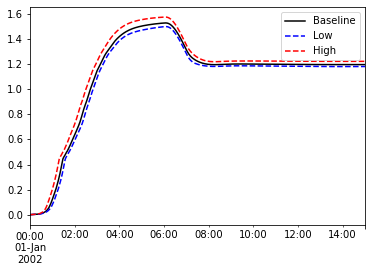

In [19]:
df.plot(style=['k-','b--','r--'])

# Clean up

In [28]:
import os

os.remove("lake_mod.sw")

In [27]:
rmtree("work")